In [ ]:
!pip install json
!pip install spacy[transformers]
!pip install emoji
!pip install contractions
!pip install textblob
!pip install torch
!pip install transformers
!pip install SentencePiece

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import emoji
import re, string, unicodedata
import nltk
import contractions
import inflect
from nltk import word_tokenize
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from transformers import AlbertTokenizer, AlbertModel
import pandas as pd
import numpy as np
import nltk
import torch
from scipy.spatial.distance import cosine
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**TRAIN**

In [ ]:
def load_instances(fn):
    instances = []
    with open(fn) as f:
        for jl_str in f:
            instances.append(json.loads(jl_str))
    
    return instances

In [ ]:
trial_instances = load_instances('/content/drive/MyDrive/TempoWiC_Starting_Kit/data/train.data.jl')

In [ ]:
def convert(s):
    new = ""
    for x in s:
        new += x
    return new

def replace_contractions(text):
    return contractions.fix(text)

def remove_URL(sample):
    return re.sub(r"http\S+", "", sample)

def remove_non_ascii(words):
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    temp=convert(new_words)
    return temp

def to_lowercase(words):
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return convert(new_words)

def remove_punctuation(words):
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', ' ', word)
        if new_word != '':
            new_words.append(new_word)
    return convert(new_words)

def replace_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return convert(new_words)

In [ ]:
texts1=[]
texts2=[]
words=[]
id=[]
for inst in trial_instances:
  t1= " ".join(emoji.demojize(inst['tweet1']['text']).replace(","," ").replace(":"," ").replace("_"," ").split())
  t1=replace_contractions(t1)
  t1=remove_URL(t1)
  t1=remove_non_ascii(t1)
  t1=remove_punctuation(t1)
  t1=replace_numbers(t1)
  t1=to_lowercase(t1)
  texts1.append(t1)

  t2=" ".join(emoji.demojize(inst['tweet2']['text']).replace(","," ").replace(":"," ").replace("_"," ").split())
  t2=replace_contractions(t2)
  t2=remove_URL(t2)
  t2=remove_non_ascii(t2)
  t2=remove_punctuation(t2)
  t2=replace_numbers(t2)
  t2=to_lowercase(t2)
  texts2.append(t2) 
  
  words.append(inst['word'])
  id.append(inst['id'])

In [ ]:
model = AlbertModel.from_pretrained("albert-base-v2",output_hidden_states = True)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2',use_fast=True)

for word in words:
  tokenizer.add_tokens(word)


model.resize_token_embeddings(len(tokenizer))  

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30013, 128)

In [ ]:
def albert_text_preparation(text, tokenizer):

    marked_text = "[CLS] " + text + " [CLS]"
    tokenized_text = remove_non_ascii(' '.join(tokenizer.tokenize(text))).split()
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1]*len(indexed_tokens)
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    return tokenized_text, tokens_tensor, segments_tensors

In [ ]:
def get_albert_embeddings(tokens_tensor, segments_tensors, model):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2][1:]

    token_embeddings = hidden_states[-1]
    token_embeddings = torch.squeeze(token_embeddings, dim=0)
    list_token_embeddings = [token_embed.tolist() for token_embed in token_embeddings]

    return list_token_embeddings

In [ ]:
target_word_embeddings1 = []
target_word_embeddings2 = []
for text,word,ids in zip(texts1,words,id):
    tokenizer.add_tokens(word)
    tokenized_text, tokens_tensor, segments_tensors = albert_text_preparation(text, tokenizer)
    list_token_embeddings = get_albert_embeddings(tokens_tensor, segments_tensors, model)
    word_index = tokenized_text.index(word)
    word_embedding = list_token_embeddings[word_index]
    target_word_embeddings1.append(word_embedding)

for text,word in zip(texts2,words):
    tokenizer.add_tokens(word)
    tokenized_text, tokens_tensor, segments_tensors = albert_text_preparation(text, tokenizer)
    list_token_embeddings =get_albert_embeddings(tokens_tensor, segments_tensors, model)
    word_index = tokenized_text.index(word)
    word_embedding = list_token_embeddings[word_index]
    target_word_embeddings2.append(word_embedding)


len(target_word_embeddings1)
len(target_word_embeddings2)

1428

In [ ]:

list_of_distances = []
for text1,text2,embed1,embed2 in zip(texts1,texts2,target_word_embeddings1,target_word_embeddings2):
  cos_dist = 1 - cosine(embed1, embed2)
  list_of_distances.append([text1, text2, cos_dist])

distances_df = pd.DataFrame(list_of_distances, columns=['text1', 'text2', 'distance'])
distances_df.head()

,text1,text2,distance
0,my new most wanted character in smash is frisk...,i was surprised by how much applause bloomberg...,0.556760
1,imagine seeing qoute from cave story making it...,bloomberg are you people for real onesix case...,0.445357
2,frisk and sans are my two favorite undertale c...,today in my wrongful convictions class we list...,0.404523
3,we do not like the search and frisk so this bi...,who the fuck is listening to mike bloomberg ra...,0.633333
4,hey guys i am wondering if anybody would draw ...,how about stop in frisk happened in mostly min...,0.849723


In [ ]:
column_names=["target_word","y_train"]
tsv_data = pd.read_csv('/content/drive/MyDrive/TempoWiC_Starting_Kit/data/train.labels.tsv', sep='\t', names=column_names)
tsv_data.head()

,target_word,y_train
0,3347-frisk,0
1,3349-frisk,0
2,3350-frisk,0
3,3351-frisk,1
4,3352-frisk,0


In [ ]:
fpr, tpr, thresholds = roc_curve(tsv_data['y_train'], distances_df['distance'])
f1_ls = []
for thres in thresholds:
    y_pred = np.where(distances_df['distance']>thres,1,0)
    f1_ls.append(f1_score(tsv_data['y_train'], y_pred, average='macro'))
    
f1_ls = pd.concat([pd.Series(thresholds), pd.Series(f1_ls)],axis=1)
f1_ls.columns = ['thresholds', 'f1']
f1_ls.sort_values(by='f1', ascending=False, inplace=True)
f1_ls.head()

,thresholds,f1
291,0.557967,0.528416
289,0.559754,0.527772
293,0.556999,0.527607
292,0.557514,0.527400
290,0.558883,0.527378


In [ ]:
thres=f1_ls.iloc[0].thresholds
thres

0.5579671338411639

**VALIDATION**

In [ ]:
val_instances = load_instances('/content/drive/MyDrive/TempoWiC_Starting_Kit/data/validation.data.jl')

In [ ]:
texts1_val=[]
texts2_val=[]
words_val=[]
id_val=[]
for inst in val_instances:
  t1= " ".join(emoji.demojize(inst['tweet1']['text']).replace(",","").replace(":"," ").replace("_"," ").split())
  t1=replace_contractions(t1)
  t1=remove_URL(t1)
  t1=remove_non_ascii(t1)
  t1=remove_punctuation(t1)
  t1=replace_numbers(t1)
  t1=to_lowercase(t1)
  t2=" ".join(emoji.demojize(inst['tweet2']['text']).replace(",","").replace(":"," ").replace("_"," ").split())
  t2=replace_contractions(t2)
  t2=remove_URL(t2)
  t2=remove_non_ascii(t2)
  t2=remove_punctuation(t2)
  t2=replace_numbers(t2)
  t2=to_lowercase(t2)
  texts1_val.append(t1)
  texts2_val.append(t2)
  words_val.append(inst['word'])
  id_val.append(inst['id'])

In [ ]:
model = AlbertModel.from_pretrained("albert-base-v2",output_hidden_states = True)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2',use_fast=True)

for word in words_val:
  tokenizer.add_tokens(word)

model.resize_token_embeddings(len(tokenizer))  

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertModel: ['predictions.bias', 'predictions.LayerNorm.weight', 'predictions.dense.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.decoder.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30003, 128)

In [ ]:
target_word_embeddings1 = []
target_word_embeddings2 = []
wordem=[]

for text,word,ids in zip(texts1_val,words_val,id_val):
    tokenizer.add_tokens(word)
    tokenized_text, tokens_tensor, segments_tensors = albert_text_preparation(text, tokenizer)
    list_token_embeddings = get_albert_embeddings(tokens_tensor, segments_tensors, model)
    word_index = tokenized_text.index(word)
    word_embedding = list_token_embeddings[word_index]
    target_word_embeddings1.append(word_embedding)

for text,word in zip(texts2_val,words_val):
    tokenizer.add_tokens(word)
    tokenized_text, tokens_tensor, segments_tensors = albert_text_preparation(text, tokenizer)
    list_token_embeddings = get_albert_embeddings(tokens_tensor, segments_tensors, model)
    word_index = tokenized_text.index(word)
    word_embedding = list_token_embeddings[word_index]
    target_word_embeddings2.append(word_embedding)


len(target_word_embeddings1)
len(target_word_embeddings2)

396

In [ ]:
list_of_distances = []
for text1,text2,embed1,embed2 in zip(texts1_val,texts2_val,target_word_embeddings1,target_word_embeddings2):
  cos_dist = 1 - cosine(embed1, embed2)
  list_of_distances.append([text1, text2, cos_dist])

distances_df = pd.DataFrame(list_of_distances, columns=['text1', 'text2', 'distance'])

distances_df.head()

,text1,text2,distance
0,impostor syndrome hitting real hard today lmao,good morning everyone except this impostor syn...,0.255634
1,had my coffee with a splash of impostor syndro...,i have out of this world impostor reads but i ...,0.573776
2,rejected one six phdchat this week on a...,cries played among us with strangers i was the...,0.553889
3,til that the proper way to spell imposter is...,onest game as an impostor ever was a fat w smi...,0.552622
4,my impostor syndrome around the music building...,it pisses me off when a player rats out his fe...,0.473282


In [ ]:
column_names=["target_word","y_train"]
tsv_data_val = pd.read_csv('/content/drive/MyDrive/TempoWiC_Starting_Kit/data/validation.labels.tsv', sep='\t', names=column_names)
tsv_data_val

,target_word,y_train
0,1670-impostor,1
1,1671-impostor,1
2,1672-impostor,0
3,1673-impostor,0
4,1674-impostor,0
...,...,...
391,3940-primo,1
392,3941-primo,0
393,3942-primo,1
394,3943-primo,1


In [ ]:
y_pred_val = np.where(distances_df['distance']>thres,1,0)

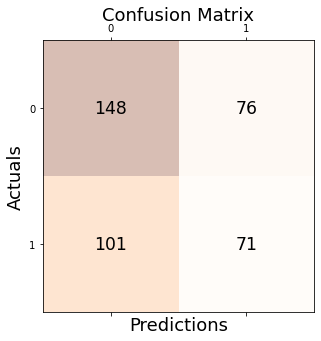

In [ ]:
conf_matrix = confusion_matrix(y_true=tsv_data_val['y_train'], y_pred=y_pred_val)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
print('F1 Score: %.3f' % f1_score(tsv_data_val['y_train'], y_pred_val,average='macro'))

F1 Score: 0.535


In [ ]:
print('Precision: %.3f' % precision_score(tsv_data_val['y_train'], y_pred_val))

Precision: 0.483


In [ ]:
print('Recall: %.3f' % recall_score(tsv_data_val['y_train'], y_pred_val))

Recall: 0.413


In [ ]:
print('Accuracy: %.3f' % accuracy_score(tsv_data_val['y_train'], y_pred_val))

Accuracy: 0.553


**TEST**

In [ ]:
test_instances = load_instances('/content/drive/MyDrive/TempoWiC_Starting_Kit/data/test-codalab-10k.data.jl')

In [ ]:
texts1_test=[]
texts2_test=[]
words_test=[]
id_test=[]
for inst in test_instances:
  t1= " ".join(emoji.demojize(inst['tweet1']['text']).replace(","," ").replace(":"," ").replace("_"," ").split())
  t1=replace_contractions(t1)
  t1=remove_URL(t1)
  t1=remove_non_ascii(t1)
  t1=remove_punctuation(t1)
  t1=replace_numbers(t1)
  t1=to_lowercase(t1)
  t2=" ".join(emoji.demojize(inst['tweet2']['text']).replace(","," ").replace(":"," ").replace("_"," ").split())
  t2=replace_contractions(t2)
  t2=remove_URL(t2)
  t2=remove_non_ascii(t2)
  t2=remove_punctuation(t2)
  t2=replace_numbers(t2)
  t2=to_lowercase(t2)
  texts1_test.append(t1)
  texts2_test.append(t2)
  words_test.append(inst['word'])
  id_test.append(inst['id'])

In [ ]:
model = AlbertModel.from_pretrained("albert-base-v2",output_hidden_states = True)
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2',use_fast=True)

for word in words_test:
  tokenizer.add_tokens(word)

model.resize_token_embeddings(len(tokenizer))  

In [ ]:
target_word_embeddings1_test = []
target_word_embeddings2_test = []


for text,word,ids in zip(texts1_test,words_test,id_test):
    tokenizer.add_tokens(word)
    tokenized_text, tokens_tensor, segments_tensors = albert_text_preparation(text, tokenizer)
    list_token_embeddings = get_albert_embeddings(tokens_tensor, segments_tensors, model)
    word_index = tokenized_text.index(word)
    word_embedding = list_token_embeddings[word_index]
    target_word_embeddings1_test.append(word_embedding)

for text,word in zip(texts2_test,words_test):
    tokenizer.add_tokens(word)
    tokenized_text, tokens_tensor, segments_tensors = albert_text_preparation(text, tokenizer)
    list_token_embeddings = get_albert_embeddings(tokens_tensor, segments_tensors, model)   
    word_index = tokenized_text.index(word)
    word_embedding = list_token_embeddings[word_index]
    target_word_embeddings2_test.append(word_embedding)


len(target_word_embeddings1_test)
len(target_word_embeddings2_test)

In [ ]:
list_of_distances = []
for text1,text2,embed1,embed2 in zip(texts1_test,texts2_test,target_word_embeddings1_test,target_word_embeddings2_test):
  cos_dist = 1 - cosine(embed1, embed2)
  list_of_distances.append([text1, text2, cos_dist])

distances_df = pd.DataFrame(list_of_distances, columns=['text1', 'text2', 'distance'])
distances_df

In [ ]:
y_pred_test = np.where(distances_df['distance']>thres,1,0)

In [ ]:
with open('/content/drive/MyDrive/TempoWiC_Starting_Kit Evaluation/TempoWiC_Starting_Kit/predictions/test.albert-preds.tsv', 'w') as preds_f:
  for inst_id, pred in zip(id_test,y_pred_test):
    preds_f.write(f"{inst_id}\t{pred}\n")